In [1]:
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Data Loading

In [6]:
fmnist_train = datasets.FashionMNIST(
    root="fmnist", 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
fmnist_test = datasets.FashionMNIST(
    root="fmnist", 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

### Data Preprocess

In [4]:
class mnist_dataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        super().__init__()

        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx], self.targets[idx]

        if self.transform:
              x = self.transform(x)
        if self.target_transform:
              y = self.target_transform(y)

        return x, y
    

def split_train_valid(dataset, valid_ratio=0.1):
    n_valid = int(len(dataset) * valid_ratio)

    train_data = dataset.data[:-n_valid].numpy()
    valid_data = dataset.data[-n_valid:].numpy()
    train_targets = dataset.targets[:-n_valid]
    valid_targets = dataset.targets[-n_valid:]

    train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
    valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

    return train, valid

In [7]:
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_train)

mnists = {}
mnists["fmnist"] = {"train": fmnist_train, "valid": fmnist_valid, "test": fmnist_test}

In [17]:
loaders = {}
for k in mnists.keys():
    loaders[k] = {s: DataLoader(dataset=mnists[k][s], 
                                batch_size=64, 
                                shuffle= s == "train", 
                                drop_last=True) for s in ["train", "valid", "test"]}

In [18]:
loaders

{'fmnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x148ab29e040>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x148ab1b04c0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x148ab30ed90>}}

### Build Models

In [8]:
# With Dropout
class DropoutClassifier(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, n_class),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# With batch normalization
class BNClassifier(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_class),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# With both
class DropoutBNClassifier(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, n_class),
        )

    def forward(self, x):
        return self.model(x)

### Train each models

In [14]:
class Trainer(nn.Module):
    def __init__(self, model_class, loaders, n_class=10, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
        super().__init__()

        self.model = model_class(n_class=n_class)
        self.loss = nn.CrossEntropyLoss()

        self.train_loader = loaders["train"]
        self.valid_loader = loaders["valid"]
        self.test_loader = loaders["test"]

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
        pass

    def _get_optimizer(self, opt, lr=0.001):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

    def train(self, max_epochs=10):
        print("===== Train Start =====")
        history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
        for e in range(max_epochs):
            train_loss, train_acc = self._train_epoch()
            valid_loss, valid_acc = self._valid_epoch()

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["valid_loss"].append(valid_loss)
            history["valid_acc"].append(valid_acc)

            if self.has_scheduler:
                self.scheduler.step()

            if e % 5 == 0:
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

        self.plot_history(history)

    def _train_epoch(self):
        epoch_loss, epoch_acc = 0, 0
        self.model.train()
        for (x, y) in self.train_loader:
            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = self.model(x)
            loss = self.loss(y_hat, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.to("cpu").item()
            epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(self.train_loader)
        epoch_acc /= len(self.train_loader)

        return epoch_loss, epoch_acc

    def _valid_epoch(self):
        epoch_loss, epoch_acc = 0, 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in self.valid_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                epoch_loss += loss.to("cpu").item()
                epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(self.valid_loader)
        epoch_acc /= len(self.valid_loader)

        return epoch_loss, epoch_acc

    def plot_history(self, history):
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["train_loss"], color="red", label="train loss")
        ax.plot(history["valid_loss"], color="blue", label="valid loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["train_acc"], color="red", label="train acc")
        ax.plot(history["valid_acc"], color="blue", label="valid acc")
        ax.set_title("Acc")
        ax.legend()

        # fig.show()

    def test(self):
        print("===== Test Start =====")
        epoch_loss, epoch_acc = 0, 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in self.test_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                epoch_loss += loss.to("cpu").item()
                epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(self.test_loader)
        epoch_acc /= len(self.test_loader)

        print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.698258, train acc: 0.747127, valid loss: 0.447815, valid acc: 0.836022
Epoch: 5, train loss: 0.409043, train acc: 0.853462, valid loss: 0.360834, valid acc: 0.868616
Epoch: 10, train loss: 0.366306, train acc: 0.865269, valid loss: 0.328490, valid acc: 0.880544
Epoch: 15, train loss: 0.345685, train acc: 0.873147, valid loss: 0.324321, valid acc: 0.880208
Epoch: 20, train loss: 0.333812, train acc: 0.879541, valid loss: 0.312760, valid acc: 0.882392
Epoch: 25, train loss: 0.318717, train acc: 0.883656, valid loss: 0.311181, valid acc: 0.886089
===== Test Start =====
Test loss: 0.334605, Test acc: 0.883113


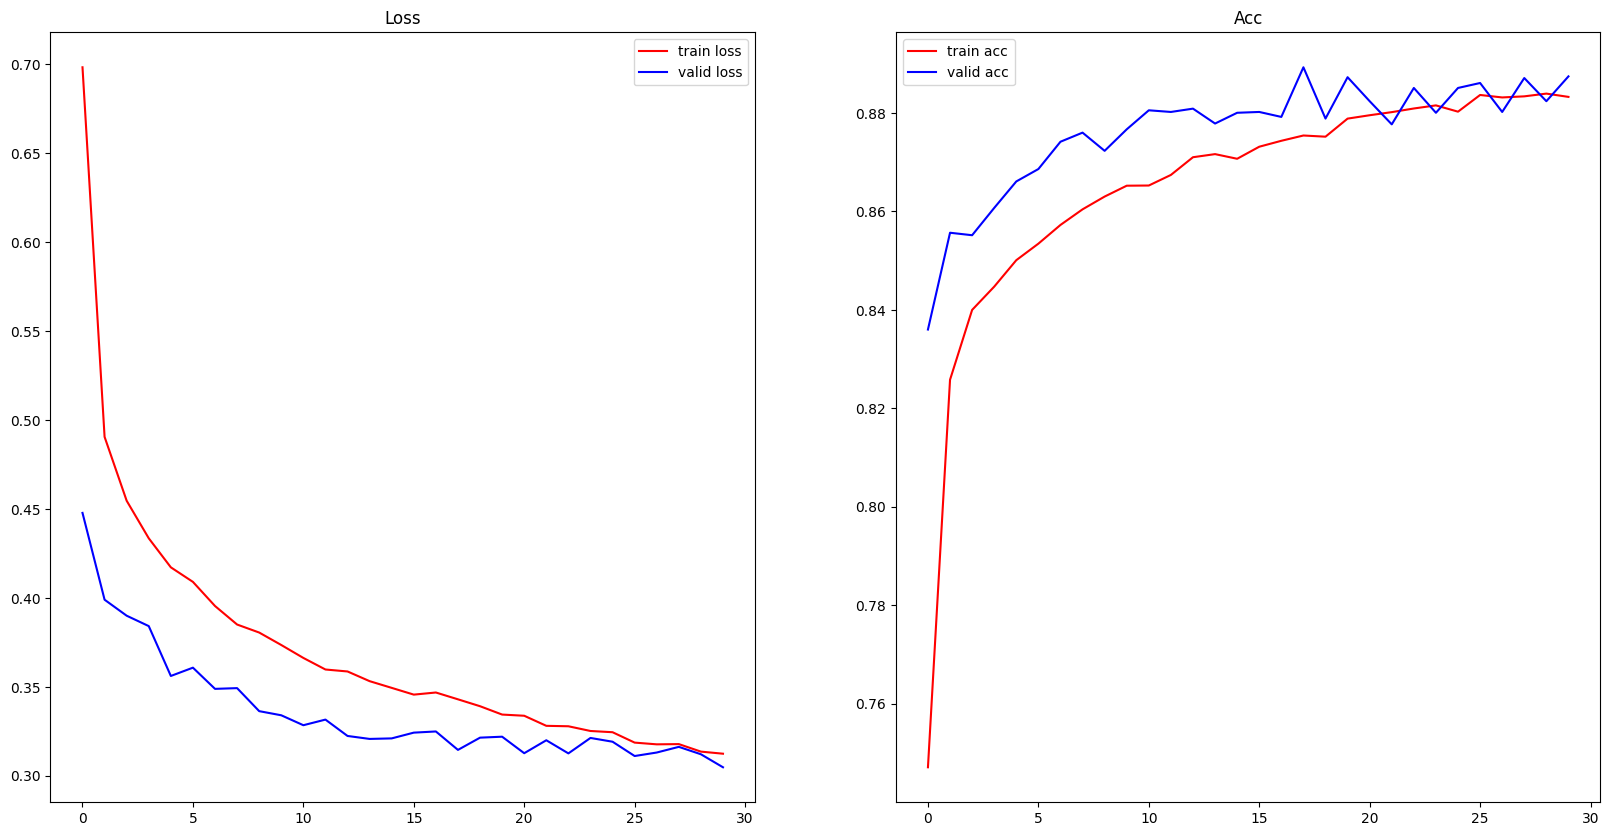

In [19]:
# With Dropout
trainer = Trainer(model_class=DropoutClassifier, 
                  loaders=loaders["fmnist"], 
                  n_class=10, 
                  opt="adam", 
                  lr=0.001, 
                  device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.454567, train acc: 0.839746, valid loss: 0.359624, valid acc: 0.869120
Epoch: 5, train loss: 0.239457, train acc: 0.910050, valid loss: 0.312875, valid acc: 0.890457
Epoch: 10, train loss: 0.173903, train acc: 0.934127, valid loss: 0.313787, valid acc: 0.891129
Epoch: 15, train loss: 0.129315, train acc: 0.952458, valid loss: 0.350106, valid acc: 0.890625
Epoch: 20, train loss: 0.102037, train acc: 0.961781, valid loss: 0.359205, valid acc: 0.893313
Epoch: 25, train loss: 0.079912, train acc: 0.970622, valid loss: 0.392333, valid acc: 0.893649
===== Test Start =====
Test loss: 0.457593, Test acc: 0.892628


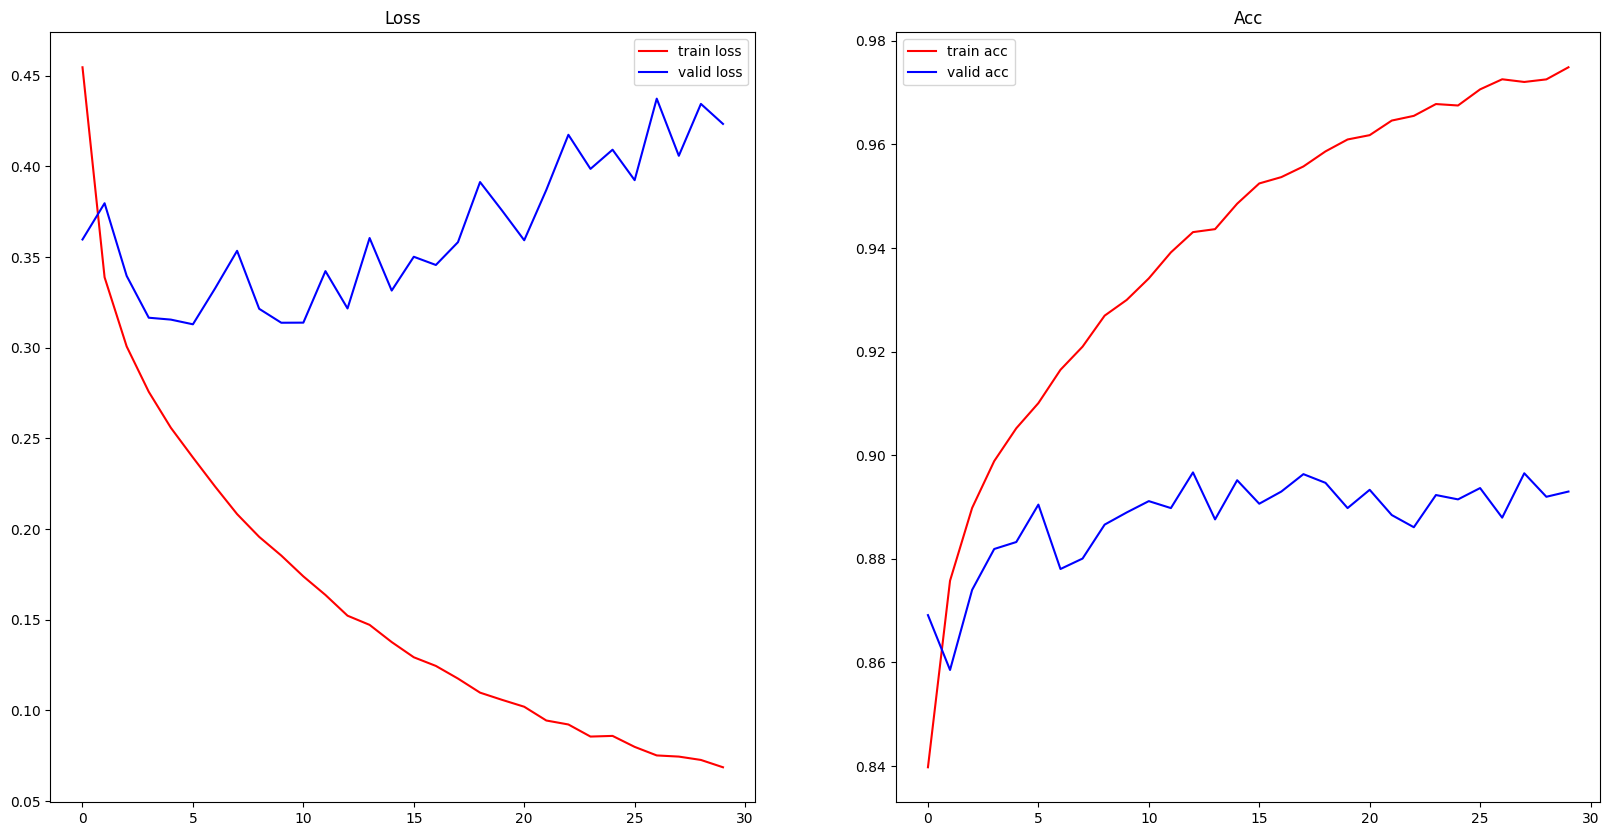

In [20]:
# With batch normalization
trainer = Trainer(model_class=BNClassifier, 
                  loaders=loaders["fmnist"], 
                  n_class=10, 
                  opt="adam", 
                  lr=0.001, 
                  device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.628247, train acc: 0.786551, valid loss: 0.416667, valid acc: 0.846606
Epoch: 5, train loss: 0.382688, train acc: 0.861581, valid loss: 0.329317, valid acc: 0.881384
Epoch: 10, train loss: 0.343465, train acc: 0.874870, valid loss: 0.316519, valid acc: 0.882728
Epoch: 15, train loss: 0.317079, train acc: 0.884546, valid loss: 0.300666, valid acc: 0.889785
Epoch: 20, train loss: 0.295993, train acc: 0.891385, valid loss: 0.292399, valid acc: 0.894657
Epoch: 25, train loss: 0.285386, train acc: 0.896630, valid loss: 0.288839, valid acc: 0.896337
===== Test Start =====
Test loss: 0.305550, Test acc: 0.893229


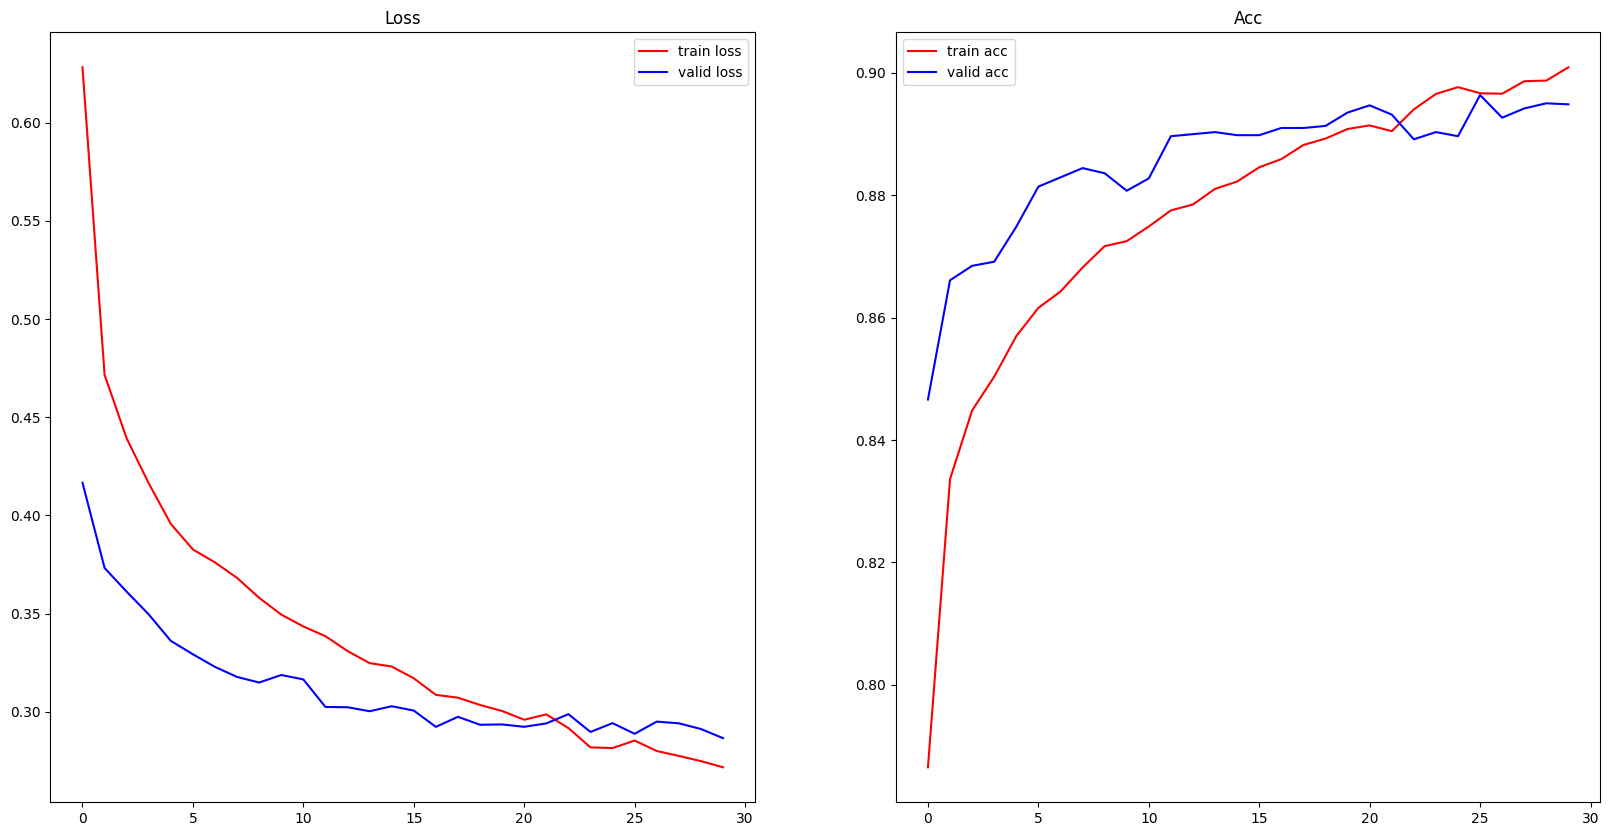

In [21]:
# With both
trainer = Trainer(model_class=DropoutBNClassifier, 
                  loaders=loaders["fmnist"], 
                  n_class=10, 
                  opt="adam", 
                  lr=0.001, 
                  device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()